In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt
import nibabel as nib

import os

from tensorflow import keras
from keras.layers import (
    Input, 
    Conv2D, 
    MaxPool2D, 
    Conv2DTranspose, 
    CenterCrop, 
    Concatenate
)

os.chdir('../../')

In [2]:
DATA_FOLDER = 'data/BRATS'

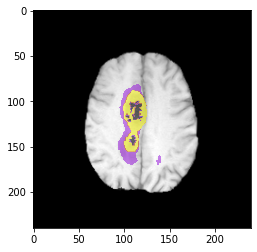

In [35]:
def plot_mri(file_path: str, selected_slice: int, *, segmentation_path: str = None):

    img = nib.load(f"{file_path}").get_fdata()
    img_slice = img[:, :, selected_slice]

    if segmentation_path:
        label = nib.load(f"{segmentation_path}").get_fdata()
        label_slice = label[:, :, selected_slice]

        label_masked = np.ma.masked_where(label_slice == 0, label_slice)

        plt.imshow(img_slice.T, cmap="gray")
        plt.imshow(label_masked.T, cmap="gnuplot", alpha=0.5)
    else:
        plt.imshow(img_slice.T, cmap="gray")

    plt.show()


plot_mri("data/BRATS/original/0.nii", 100, segmentation_path="data/BRATS/labels/0.nii")


In [ ]:
def create_standard_unet():
    # ======================== CONTRACTING PATH ==========================

    inputs = Input(shape=(572, 572, 1))                      # 572x572x1

    conv_1_1 = Conv2D(64, 3, activation='relu')(inputs)      # 570x570x64
    conv_1_2 = Conv2D(64, 3, activation='relu')(conv_1_1)    # 568x568x64

    pool_1 = MaxPool2D((2,2), strides=2)(conv_1_2)           # 284x284x64

    conv_2_1 = Conv2D(128, 3, activation='relu')(pool_1)     # 282x282x128
    conv_2_2 = Conv2D(128, 3, activation='relu')(conv_2_1)   # 280x280x128

    pool_2 = MaxPool2D((2,2), strides=2)(conv_2_2)           # 140x140x128

    conv_3_1 = Conv2D(256, 3, activation='relu')(pool_2)     # 138x138x256
    conv_3_2 = Conv2D(256, 3, activation='relu')(conv_3_1)   # 136x136x256

    pool_3 = MaxPool2D((2,2), strides=2)(conv_3_2)           # 68x68x256

    conv_4_1 = Conv2D(512, 3, activation='relu')(pool_3)     # 66x66x512
    conv_4_2 = Conv2D(512, 3, activation='relu')(conv_4_1)   # 64x64x512

    pool_4 = MaxPool2D((2,2), strides=2)(conv_4_2)           # 32x32x512

    conv_5_1 = Conv2D(1024, 3, activation='relu')(pool_4)    # 30x30x1024
    conv_5_2 = Conv2D(1024, 3, activation='relu')(conv_5_1)  # 28x28x1024

    # ======================== EXPANDING PATH ============================

    up_1 = Conv2DTranspose(512, 2, strides=2, padding='same')(conv_5_2)   # 56x56x512
    conv_4_2_crop = CenterCrop(up_1.shape[1], up_1.shape[2])(conv_4_2)    # 56x56x512

    concat_1 = Concatenate()([up_1, conv_4_2_crop])                       # 56x56x1024
    conv_6_1 = Conv2D(512, 3, activation='relu')(concat_1)                # 54x54x512
    conv_6_2 = Conv2D(512, 3, activation='relu')(conv_6_1)                # 52x52x512

    up_2 = Conv2DTranspose(256, 2, strides=2, padding='same')(conv_6_2)   # 104x104x256
    conv_3_2_crop = CenterCrop(up_2.shape[1], up_2.shape[2])(conv_3_2)    # 104x104x256

    concat_2 = Concatenate()([up_2, conv_3_2_crop])                       # 104x104x512
    conv_7_1 = Conv2D(256, 3, activation='relu')(concat_2)                # 102x102x256
    conv_7_2 = Conv2D(256, 3, activation='relu')(conv_7_1)                # 100x100x256

    up_3 = Conv2DTranspose(128, 2, strides=2, padding="same")(conv_7_2)   # 200x200x128
    conv_2_2_crop = CenterCrop(up_3.shape[1], up_3.shape[2])(conv_2_2)    # 200x200x128

    concat_3 = Concatenate()([up_3, conv_2_2_crop])                       # 200x200x256
    conv_8_1 = Conv2D(128, 3, activation='relu')(concat_3)                # 198x198x128
    conv_8_2 = Conv2D(128, 3, activation='relu')(conv_8_1)                # 196x196x128

    up_4 = Conv2DTranspose(64, 2, strides=2, padding='same')(conv_8_2)    # 392x392x64
    conv_1_2_crop = CenterCrop(up_4.shape[1], up_4.shape[2])(conv_1_2)    # 392x392x64

    concat_4 = Concatenate()([up_4, conv_1_2_crop])                       # 392x392x128
    conv_9_1 = Conv2D(64, 3, activation='relu')(concat_4)                 # 390x390x64
    conv_9_2 = Conv2D(64, 3, activation='relu')(conv_9_1)                 # 388x388x64
    conv_9_3 = Conv2D(2, 1, activation='softmax')(conv_9_2)               # 388x388x2

    unet = tf.keras.Model(inputs, conv_9_3)
    return unet

In [ ]:
unet = create_standard_unet()

unet.summary(line_length=130)